In [ ]:
!pip install -U openmim
!mim install mmcv-full
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -v -e .
# "-v" means verbose, or more output
# "-e" means installing a project in editable mode,
# thus any local modifications made to the code will take effect without reinstallation.
%cd ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [ ]:
!pip install --upgrade gdown
!gdown 1EyaZVdbezIJsj8LviM7GaIBto46a1N-Z
!gdown 1L8NYh3LOSGf7xNm7TsZVXURbYYfeJVKh
!gdown 1m8fsG812o6KotF1NVo0YuiSfSn18TAOA
!gdown 1d3wU8KNjPL4EqMCIEO_rO-O3-REpG82T
!gdown 1BUtU42moYrOFbsMCE-LTTkUE-mrWnfG2
!gdown 1d7I50jVjtCddnhpf-lqj8-f13UyCzoW1
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b0.pth mit_b0_mmseg.pth
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b1.pth mit_b1_mmseg.pth
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b2.pth mit_b2_mmseg.pth
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b3.pth mit_b3_mmseg.pth
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b4.pth mit_b4_mmseg.pth
!python mmsegmentation/tools/model_converters/mit2mmseg.py mit_b5.pth mit_b5_mmseg.pth

In [ ]:
!pip install --upgrade gdown
!gdown 1Av6jCXj-3tzETie_fhTMJethHKC_6sVy
!unzip bkai-igh-neopolyp

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import glob
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.transforms import RandomGamma
import os

In [2]:
trainsize = 384

class BKpolypDataset(torch.utils.data.Dataset):
    def __init__(self, dir="path/to/data", transform=None):
        self.img_path_lst = []
        self.dir = dir
        self.transform = transform
        self.img_path_lst = glob.glob("{}/train/train/*".format(self.dir))

    def __len__(self):
        return len(self.img_path_lst)

    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, (trainsize, trainsize))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # lower boundary RED color range values; Hue (0 - 10)
        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        # upper boundary RED color range values; Hue (160 - 180)
        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 2
        # boundary RED color range values; Hue (36 - 70)
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255,255))
        green_mask[green_mask != 0] = 1
        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = full_mask.astype(np.uint8)
        return full_mask

    def __getitem__(self, idx):
        img_path = self.img_path_lst[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (trainsize, trainsize))
        label_path = img_path.replace("train", "train_gt")
        label = self.read_mask(label_path)

        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed["image"]
            label = transformed["mask"]
        return image, label

In [3]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
    A.Cutout(p=0.2, max_h_size=35, max_w_size=35, fill_value=255),
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
    A.RandomShadow(p=0.1),
    A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
    A.RandomCrop(trainsize, trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [4]:
train_dataset = BKpolypDataset(dir="/content", transform=train_transform)

In [5]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

tensor([0, 2], dtype=torch.uint8)


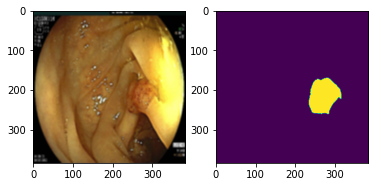

In [6]:
import random
id_test = random.randint(0, train_dataset.__len__())
sample1, sample2 = train_dataset.__getitem__(id_test)
print(torch.unique(sample2))
plt.subplot(1,2,1)
plt.imshow(unorm(sample1).permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(sample2.squeeze())
plt.show()

In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
#metrics
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target 

In [9]:
class FocalLoss_Ori(nn.Module):
    """
    This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in
    'Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)'
    Focal_Loss= -1*alpha*((1-pt)**gamma)*log(pt)
    Args:
        num_class: number of classes
        alpha: class balance factor
        gamma:
        ignore_index:
        reduction:
    """

    def __init__(self, num_class, alpha=None, gamma=2, ignore_index=None, reduction='mean'):
        super(FocalLoss_Ori, self).__init__()
        self.num_class = num_class
        self.gamma = gamma
        self.reduction = reduction
        self.smooth = 1e-4
        self.ignore_index = ignore_index
        self.alpha = alpha
        if alpha is None:
            self.alpha = torch.ones(num_class, )
        elif isinstance(alpha, (int, float)):
            self.alpha = torch.as_tensor([alpha] * num_class)
        elif isinstance(alpha, (list, np.ndarray)):
            self.alpha = torch.as_tensor(alpha)
        if self.alpha.shape[0] != num_class:
            raise RuntimeError('the length not equal to number of class')

        # if isinstance(self.alpha, (list, tuple, np.ndarray)):
        #     assert len(self.alpha) == self.num_class
        #     self.alpha = torch.Tensor(list(self.alpha))
        # elif isinstance(self.alpha, (float, int)):
        #     assert 0 < self.alpha < 1.0, 'alpha should be in `(0,1)`)'
        #     assert balance_index > -1
        #     alpha = torch.ones((self.num_class))
        #     alpha *= 1 - self.alpha
        #     alpha[balance_index] = self.alpha
        #     self.alpha = alpha
        # elif isinstance(self.alpha, torch.Tensor):
        #     self.alpha = self.alpha
        # else:
        #     raise TypeError('Not support alpha type, expect `int|float|list|tuple|torch.Tensor`')

    def forward(self, target, logit):
        # assert isinstance(self.alpha,torch.Tensor)\
        N, C = logit.shape[:2]
        alpha = self.alpha.to(logit.device)
        prob = F.softmax(logit, dim=1)
        if prob.dim() > 2:
            # N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            prob = prob.view(N, C, -1)
            prob = prob.transpose(1, 2).contiguous()  # [N,C,d1*d2..] -> [N,d1*d2..,C]
            prob = prob.view(-1, prob.size(-1))  # [N,d1*d2..,C]-> [N*d1*d2..,C]
        ori_shp = target.shape
        target = target.view(-1, 1)  # [N,d1,d2,...]->[N*d1*d2*...,1]
        valid_mask = None
        if self.ignore_index is not None:
            valid_mask = target != self.ignore_index
            target = target * valid_mask

        # ----------memory saving way--------
        prob = prob.gather(1, target).view(-1) + self.smooth  # avoid nan
        logpt = torch.log(prob)
        # alpha_class = alpha.gather(0, target.view(-1))
        alpha_class = alpha[target.squeeze().long()]
        class_weight = -alpha_class * torch.pow(torch.sub(1.0, prob), self.gamma)
        loss = class_weight * logpt
        if valid_mask is not None:
            loss = loss * valid_mask.squeeze()

        if self.reduction == 'mean':
            loss = loss.mean()
            if valid_mask is not None:
                loss = loss.sum() / valid_mask.sum()
        elif self.reduction == 'none':
            loss = loss.view(ori_shp)
        return loss

In [10]:
#device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#model settings
norm_cfg = dict(type='BN', requires_grad=True)
model_cfg = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 8, 27, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg = dict(type="Pretrained", checkpoint="mit_b4_mmseg.pth")),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=norm_cfg,
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    # model training and testing settings
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))


#load data
batch_size = 16
n_workers = os.cpu_count()
print("num_workers =", n_workers)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)

import mmcv
from mmseg.models import build_segmentor
model = build_segmentor(model_cfg).to(device)
model.init_weights()

#loss
criterion = FocalLoss_Ori(num_class=3)

#optimizer
n_eps = 50
init_lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                    T_max=len(train_loader)*n_eps,
                                    eta_min=init_lr/100)
total_step = len(train_loader)

#meter
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()

num_workers = 2


/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2023-03-03 04:38:43,333 - mmcv - INFO - initialize MixVisionTransformer with init_cfg {'type': 'Pretrained', 'checkpoint': 'mit_b4_mmseg.pth'}
2023-03-03 04:38:43,336 - mmcv - INFO - load model from: mit_b4_mmseg.pth
2023-03-03 04:38:43,339 - mmcv - INFO - load checkpo

FileNotFoundError: ignored

In [ ]:
for ep in range(1, 1+n_eps):
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(train_loader), start=1):
        if ep <= 1:
            optimizer.param_groups[0]["lr"] = (ep * batch_id) / (1.0 * total_step) * init_lr
        else:
            scheduler.step()
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model.forward_dummy(x) #(B, C, H, W)
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        #save metrics
        with torch.no_grad():
            train_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    #compute iou, dice
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10) #vector 21D
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D

        mIoU = torch.mean(iou_class[1:]) #mean vector 21D
        mDice = torch.mean(dice_class[1:]) #mean vector 21D

    print("EP {}, current_lr = {} , train loss = {} IoU = {}, dice = {}".format(ep, scheduler.get_last_lr(), train_loss_meter.avg, mIoU, mDice))

    if ep >= 40:
        torch.save(model.state_dict(), "modelSegFormer_ep_{}.pth".format(ep))

In [ ]:
color_dict = {0: (0,   0, 0),
              1: (0, 255,   0),
              2: (0, 0,   255)}

In [ ]:
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))
    for k in color_dict.keys():
        output[mask==k] = color_dict[k]
    return np.uint8(output)

In [ ]:
!mkdir test_mask
!mkdir test_overlapmask

In [ ]:
model.eval()

for i in os.listdir("test/test"):
    img_path = os.path.join("test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
      output_mask = model.forward_dummy(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=-1)
    new_rgb_mask = np.zeros((*mask.shape, 3)).astype(np.uint8)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb_true = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    overlap = 0.7*ori_img+0.3*mask_rgb_true
    overlap = overlap.astype('uint8')
    overlap = cv2.cvtColor(overlap, cv2.COLOR_RGB2BGR)
    cv2.imwrite("test_mask/{}".format(i), mask_rgb)
    cv2.imwrite("test_overlapmask/{}".format(i), overlap)
    print("processed ", img_path)

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = 'test_mask' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)